## Andreas Tsantilas Shabani Team No.1

In [86]:
from qiskit import *
from qiskit.circuit import *
from qiskit.extensions import RYGate
import math
import numpy as np
import matplotlib.pyplot as plt
from qiskit.providers.aer import *
from qiskit.quantum_info import *
from qiskit.ignis.verification import*

qiskit.__qiskit_version__

{'qiskit-terra': '0.14.2',
 'qiskit-aer': '0.5.2',
 'qiskit-ignis': '0.3.3',
 'qiskit-ibmq-provider': '0.7.2',
 'qiskit-aqua': '0.7.3',
 'qiskit': '0.19.6'}

In [87]:
def g_(sigma_, mu_, lim):
    # normalization function, equal to psi tilde squared, summed over all the integers.
    # in lieu of an infinite sum, we can simply make ``lim" sufficiently high. 
    return np.sum(np.exp((-(np.arange(-lim, lim+1, 1) - mu_)**2)/float((2)*sigma_**2)))

def angle_(sigma_, mu_, lim=10**3):
    # Calculates the angle, based on the square root of probability. 
    # cutoff the infinite sum in g_(...) at 10**3 by default
    return np.arccos(np.sqrt(g_(sigma_/2., mu_/2., lim)/g_(sigma_, mu_, lim)))

def ctrl_states(n):
    states = []
    for i in range(0,2**n):
        s = bin(i).replace("0b", "")
        states.append("".join(["0" for j in range(0,n-len(s))])+s)
    return states

def new_mu(qub, mu):
    # calculate modified \mu for n-bit string qubit
    # i.e., we have g(b, mu) = (mu - b)/2, b \in {0,1}, and g('',mu) = mu
    # e.g., h('101101', mu) = g('1',g('0',g('1',g(...)))) etc.
    new_mean = mu
    for bit in qub[::-1]:#reversed because we consider the qubits increasingly further back
        new_mean = (new_mean/2.) - ((1/2.)*int(bit))
    return new_mean

In [88]:
def create_circ(N, mu_, sig_,):
    qr = QuantumRegister(N, 'q')
    qc = QuantumCircuit(qr)# Generate a quantum circuit with a quantum register (list) of qubit objects
    alpha_0 = angle_(sig_, mu_) # We multiply by 2, because the ry gate rotates by alpha/2
    qc.ry(2*alpha_0,0) # apply a rotation angle of alpha_0 (multiply by 2 because gate halves parameter)
    for i in range(1,N): # Steps to be done at level q_i
        qstring = ctrl_states(i) # create list of 2^i strings of length i
        for k in qstring:
            alpha_ = angle_(sig_/(2**i), new_mu(k, mu_)) # Calculate angle using modified mean
            new_gate = RYGate(2*alpha_).control(num_ctrl_qubits = i, 
                                                label = None, 
                                                ctrl_state=k) # control state is 
            qc.append(new_gate, qr[:i+1]) # add ry gate to level

    return qc

## This is a noiseless simulation of the Gaussian with parameters $\mu$ and $\sigma$.

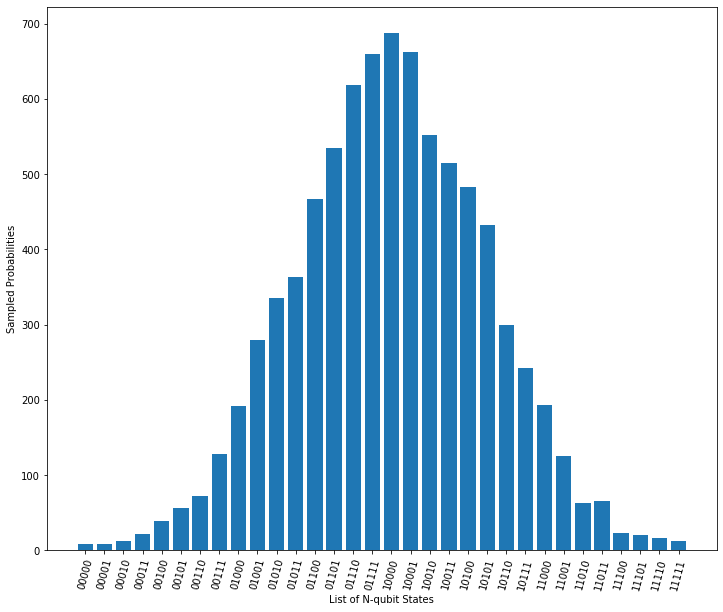

In [89]:
N = 5
sigma = 2**N/6.5
mu = 2**(N-1)

qc = create_circ(N,mu,sigma)
qc.measure_all()


backend = Aer.get_backend('qasm_simulator')
result = execute(qc, backend, shots=8192).result().get_counts()
rez = sorted(result.items())


labels, counts = zip(*rez)

plt.figure(figsize=(12, 10))
plt.xticks(rotation=75)
plt.bar(labels, counts)
plt.xlabel('List of N-qubit States')
plt.ylabel('Sampled Probabilities')
plt.show()


## We now measure goodness-of-fit

Amplitude Variance 67.7769067489545
Center  Variance 0.005185629994980825
Width Variance 0.005192091813220987


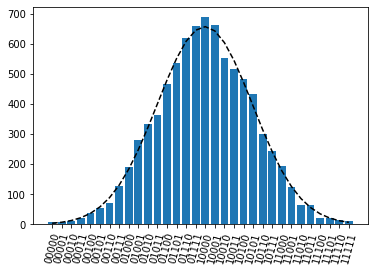

In [90]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit

def gaussian(x,a,b,c):
    return a*np.exp(-(x-b)**2/(2*c**2))

def fit_gaussian(counts):
    x = np.arange(len(counts))
    return curve_fit(gaussian,x,counts)

test_data = result
labels, counts = zip(*sorted(test_data.items()))

popt, pcov = fit_gaussian(counts)

print('Amplitude Variance',pcov[0,0])
print('Center  Variance',pcov[1,1])
print('Width Variance',pcov[2,2])

x = np.arange(len(counts))
y = gaussian(x,*popt)

plt.xticks(rotation=75)
plt.bar(labels,counts)
plt.plot(x,y,'k--')

## This is a simulation performed on 'ibmq_rome'. Results are best when no coupling map is specified. This defaults to None which seems to eliminate a lot of the noise. Feel free to replace the backend and toy around with some parameters.


<Figure size 432x288 with 0 Axes>

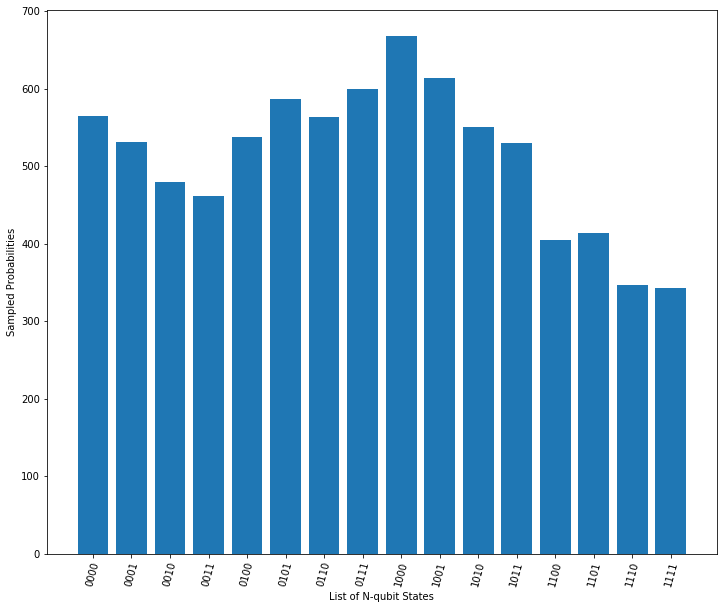

{'11111': 12, '11000': 193, '10010': 552, '11011': 66, '10110': 300, '00100': 39, '10011': 515, '00011': 22, '01010': 335, '01101': 535, '10100': 483, '00111': 128, '11101': 21, '00010': 13, '11100': 23, '10000': 688, '11110': 16, '10101': 432, '01111': 660, '01011': 363, '00001': 9, '00110': 72, '10001': 662, '01110': 619, '00000': 8, '10111': 243, '01001': 280, '11001': 125, '11010': 63, '00101': 56, '01100': 467, '01000': 192}


In [91]:
from qiskit import QuantumCircuit, execute
from qiskit import IBMQ, Aer
from qiskit.visualization import plot_histogram
import qiskit.providers.aer.noise as noise

IBMQ.disable_account()
provider = IBMQ.enable_account('acddebb030e0ef14799703e4ce5353bbd218287d8aeeb491d5194cefc5768e183f0fede81f60ccecad05e3ed98d20053094c589196ba178186282e574cd54fd2')

backend = provider.get_backend('ibmq_burlington')
noise_model = noise.NoiseModel.from_backend(backend)

# Get coupling map from backend
coupling_map = backend.configuration().coupling_map
#coupling_map = [[0,1],[1,0],[1,2],[2,1], [2,3],[3,2],[3,4],[4,3],[4,0],[0,4]]



# Get basis gates from noise model
basis_gates = noise_model.basis_gates

N = 4
sigma = 2**N/6.5
mu = 2**(N-1)

qc = create_circ(N,mu,sigma)
qc.measure_all()

# Perform a noise simulation
result2 = execute(qc, Aer.get_backend('qasm_simulator'), shots = 8192,
                 coupling_map=None, #coupling_map,
                 basis_gates=basis_gates,
                 noise_model=noise_model).result().get_counts()



rez2 = sorted(result2.items())

labels, counts = zip(*rez2)

plt.clf()

plt.figure(figsize=(12, 10))
plt.xticks(rotation=75)
plt.bar(labels, counts)
plt.xlabel('List of N-qubit States')
plt.ylabel('Sampled Probabilities')
plt.show()

print(result)

Amplitude Variance 508.97036926346414
Center  Variance 0.3280908358005118
Width Variance 1.049472329684841


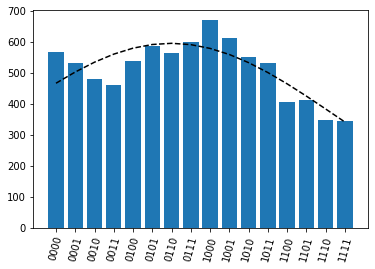

In [92]:
test_data = result2
labels, counts = zip(*sorted(test_data.items()))

popt, pcov = fit_gaussian(counts)

print('Amplitude Variance',pcov[0,0])
print('Center  Variance',pcov[1,1])
print('Width Variance',pcov[2,2])

x = np.arange(len(counts))
y = gaussian(x,*popt)

plt.xticks(rotation=75)
plt.bar(labels,counts)
plt.plot(x,y,'k--')

## Next, we may consider a custom circuit, which allows us to isolate each type of error. We can observe its effects on the Gaussian:


<Figure size 432x288 with 0 Axes>

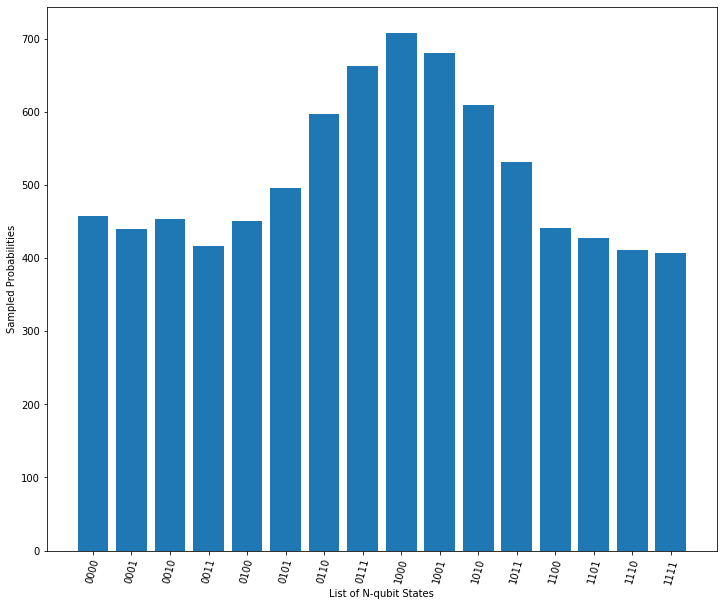

{'11111': 7, '11000': 165, '10010': 610, '11011': 53, '10110': 301, '00100': 27, '10011': 525, '00011': 26, '01010': 325, '01101': 551, '10100': 475, '00111': 128, '11101': 21, '00010': 9, '11100': 42, '10000': 676, '11110': 6, '10101': 394, '01111': 638, '01011': 395, '00001': 7, '00110': 88, '10001': 676, '01110': 627, '00000': 4, '10111': 261, '01001': 241, '11001': 134, '11010': 97, '00101': 52, '01100': 461, '01000': 170}


In [80]:
# Depolarizing Error probabilities
prob_1 = 0.001  # 1-qubit gate
prob_2 = 0.01   # 2-qubit gate

# Qubit reset probabilities
prob_3 = .7
prob_4 = .3

# Depolarizing quantum errors
error_1 = noise.depolarizing_error(prob_1, 1)
error_2 = noise.depolarizing_error(prob_2, 2)

# Qubit reset errors
error_3 = noise.reset_error(prob_3, prob_4)
error_4 = noise.reset_error(prob_3, prob_4)



noise_model = noise.NoiseModel()
noise_model.add_all_qubit_quantum_error(error_1, ['u1', 'u2', 'u3'])
noise_model.add_all_qubit_quantum_error(error_2, ['cx'])


# Get basis gates from noise model
basis_gates = noise_model.basis_gates

N = 4
sigma = 2**N/6.5
mu = 2**(N-1)

qc = create_circ(N,mu,sigma)
qc.measure_all()

# Perform a noise simulation
result3 = execute(qc, Aer.get_backend('qasm_simulator'), shots = 8192,
                 coupling_map=None,
                 basis_gates=basis_gates,
                 noise_model=noise_model).result().get_counts()



rez3 = sorted(result3.items())

labels, counts = zip(*rez3)

plt.clf()

plt.figure(figsize=(12, 10))
plt.xticks(rotation=75)
plt.bar(labels, counts)
plt.xlabel('List of N-qubit States')
plt.ylabel('Sampled Probabilities')
plt.show()

print(result)

Amplitude Variance 765.6714761256494
Center  Variance 0.20515784408028354
Width Variance 0.6341710356002096


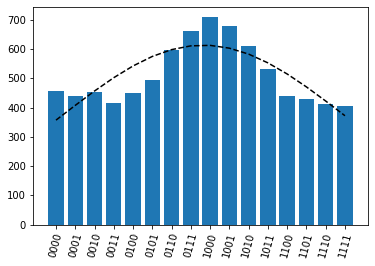

In [81]:
test_data = result3
labels, counts = zip(*sorted(test_data.items()))

popt, pcov = fit_gaussian(counts)

print('Amplitude Variance',pcov[0,0])
print('Center  Variance',pcov[1,1])
print('Width Variance',pcov[2,2])

x = np.arange(len(counts))
y = gaussian(x,*popt)

plt.xticks(rotation=75)
plt.bar(labels,counts)
plt.plot(x,y,'k--')